In [61]:
# @title Imports and Installs

# Praw Install
!pip install praw

# General Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf

# Classification Model Imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, fbeta_score
from sklearn.inspection import permutation_importance

# Neural Net Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Sentiment Analyzer Imports
import praw
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Commodities
Because we are analyzing the price changes of different commodities, we are using ETFs for price data. These values represent either the spot price (how much to buy the commodity now) or the futures price (how much to buy the commodity in the future). We use the following 9 ETFs, spanning across precious metals, fuels, and agriculture.


*   GLD = SPDR Gold Shares (Spot Price)
*   SLV	= iShares Silver Trust (Spot Price)
*   PPLT = abrdn Physical Platinum Shares ETF (Spot Price)
*   CPER = United States Copper Index Fund (Futures)
*   USO = United States Oil Fund (Futures)
*   UNG = United States Natural Gas Fund (Futures)
*   WEAT = Teucrium Wheat Fund (Futures)
*   SOYB = Teucrium Soybean Fund (Futures)
*   CORN = Teucrium Corn Fund (Futures)


The ETF we are interested in classifying is VGT, Vanguard's Information Technology Index Fund.








In [62]:
# Initialize tickers of commodities
commodities = ['GLD', 'SLV', 'PPLT', 'CPER', 'USO', 'UNG', 'WEAT', 'SOYB', 'CORN', 'VGT']

# Pulling YFinance Data
Using the yfinance API, we can access information about any stock. Given this data, we pull closing prices to make our analysis. All of this information is stored in commodity_prices_data to be transformed into a data frame for convenience.

In [63]:
# Initalize a list to keep data
commodity_prices_data = []

# Attempt to pull data and provide an error code
for commodity in commodities:
  try:
    # Pull historical prices
    commodity_prices = yf.Ticker(commodity).history(period = "10y")['Close']
    commodity_prices.rename(commodity, inplace=True)
    print(f'{commodity} data fetch successful')

    # Append data to list
    commodity_prices_data.append(commodity_prices)
  except Exception as e:
    print(f'Error: exception {e}')

GLD data fetch successful
SLV data fetch successful
PPLT data fetch successful
CPER data fetch successful
USO data fetch successful
UNG data fetch successful
WEAT data fetch successful
SOYB data fetch successful
CORN data fetch successful
VGT data fetch successful


In [64]:
# Convert data to DataFrame
commodity_df = pd.concat(commodity_prices_data, axis=1)
commodity_df

,GLD,SLV,PPLT,CPER,USO,UNG,WEAT,SOYB,CORN,VGT
Date,,,,,,,,,,
2015-12-17 00:00:00-05:00,100.500000,13.080000,81.290001,13.630000,85.919998,110.720001,47.000000,17.580000,22.080000,99.149055
2015-12-18 00:00:00-05:00,102.040001,13.430000,82.930000,14.020000,85.279999,111.360001,47.250000,17.920000,22.129999,97.188065
2015-12-21 00:00:00-05:00,103.150002,13.590000,84.110001,14.270000,85.279999,118.879997,46.700001,17.830000,22.000000,98.141335
2015-12-22 00:00:00-05:00,102.610001,13.590000,83.940002,13.960000,86.160004,116.800003,46.150002,17.780001,21.700001,98.785919
2015-12-23 00:00:00-05:00,102.309998,13.620000,83.790001,14.100000,90.080002,121.440002,45.750000,17.670000,21.639999,99.654312
...,...,...,...,...,...,...,...,...,...,...
2025-12-10 00:00:00-05:00,389.049988,56.070000,150.619995,33.070000,70.540001,14.260000,20.510000,22.780001,17.830000,779.159973
2025-12-11 00:00:00-05:00,393.239990,57.619999,154.649994,33.610001,69.250000,13.080000,20.670000,22.820000,17.900000,776.340027
2025-12-12 00:00:00-05:00,395.440002,56.099998,159.029999,32.830002,68.809998,12.730000,20.530001,22.520000,17.750000,753.929993


# Working with the Data
With this data, we can plot the commodity prices over time. However, we are interested in how the change in commodity prices affect VGT's direction of movement. So, we calculate and plot percent change. Additionally, we will shift the VGT percent change such that the commodity changes for a specific trading day will be aligned with the VGT change in the next day.

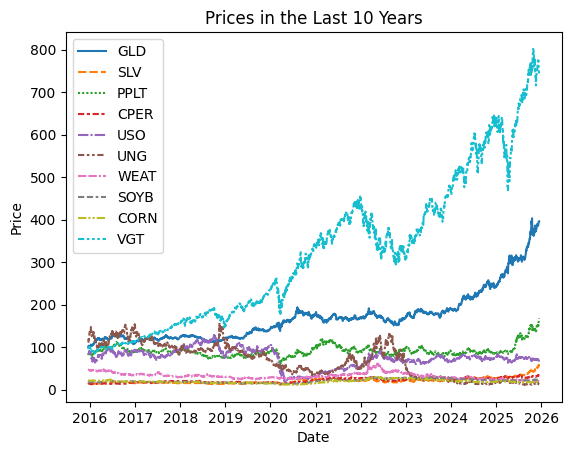

In [65]:
# Plot
ax = sns.lineplot(data = commodity_df)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Prices in the Last 10 Years');

In [66]:
# Initialize percent change
commodity_pct_change = commodity_df.pct_change()
commodity_pct_change.dropna(inplace=True)
commodity_pct_change

,GLD,SLV,PPLT,CPER,USO,UNG,WEAT,SOYB,CORN,VGT
Date,,,,,,,,,,
2015-12-18 00:00:00-05:00,0.015323,0.026758,0.020175,0.028613,-0.007449,0.005780,0.005319,0.019340,0.002264,-0.019778
2015-12-21 00:00:00-05:00,0.010878,0.011914,0.014229,0.017832,0.000000,0.067529,-0.011640,-0.005022,-0.005874,0.009809
2015-12-22 00:00:00-05:00,-0.005235,0.000000,-0.002021,-0.021724,0.010319,-0.017497,-0.011777,-0.002804,-0.013636,0.006568
2015-12-23 00:00:00-05:00,-0.002924,0.002207,-0.001787,0.010029,0.045497,0.039726,-0.008667,-0.006187,-0.002765,0.008791
2015-12-24 00:00:00-05:00,0.007233,0.005139,0.015992,0.003546,0.003552,0.013175,-0.003279,-0.008489,-0.002311,-0.000457
...,...,...,...,...,...,...,...,...,...,...
2025-12-10 00:00:00-05:00,0.004259,0.016313,-0.025681,0.012864,0.009734,0.011348,-0.006780,0.002200,-0.006685,0.003607
2025-12-11 00:00:00-05:00,0.010770,0.027644,0.026756,0.016329,-0.018288,-0.082749,0.007801,0.001756,0.003926,-0.003619
2025-12-12 00:00:00-05:00,0.005595,-0.026380,0.028322,-0.023207,-0.006354,-0.026758,-0.006773,-0.013146,-0.008380,-0.028866


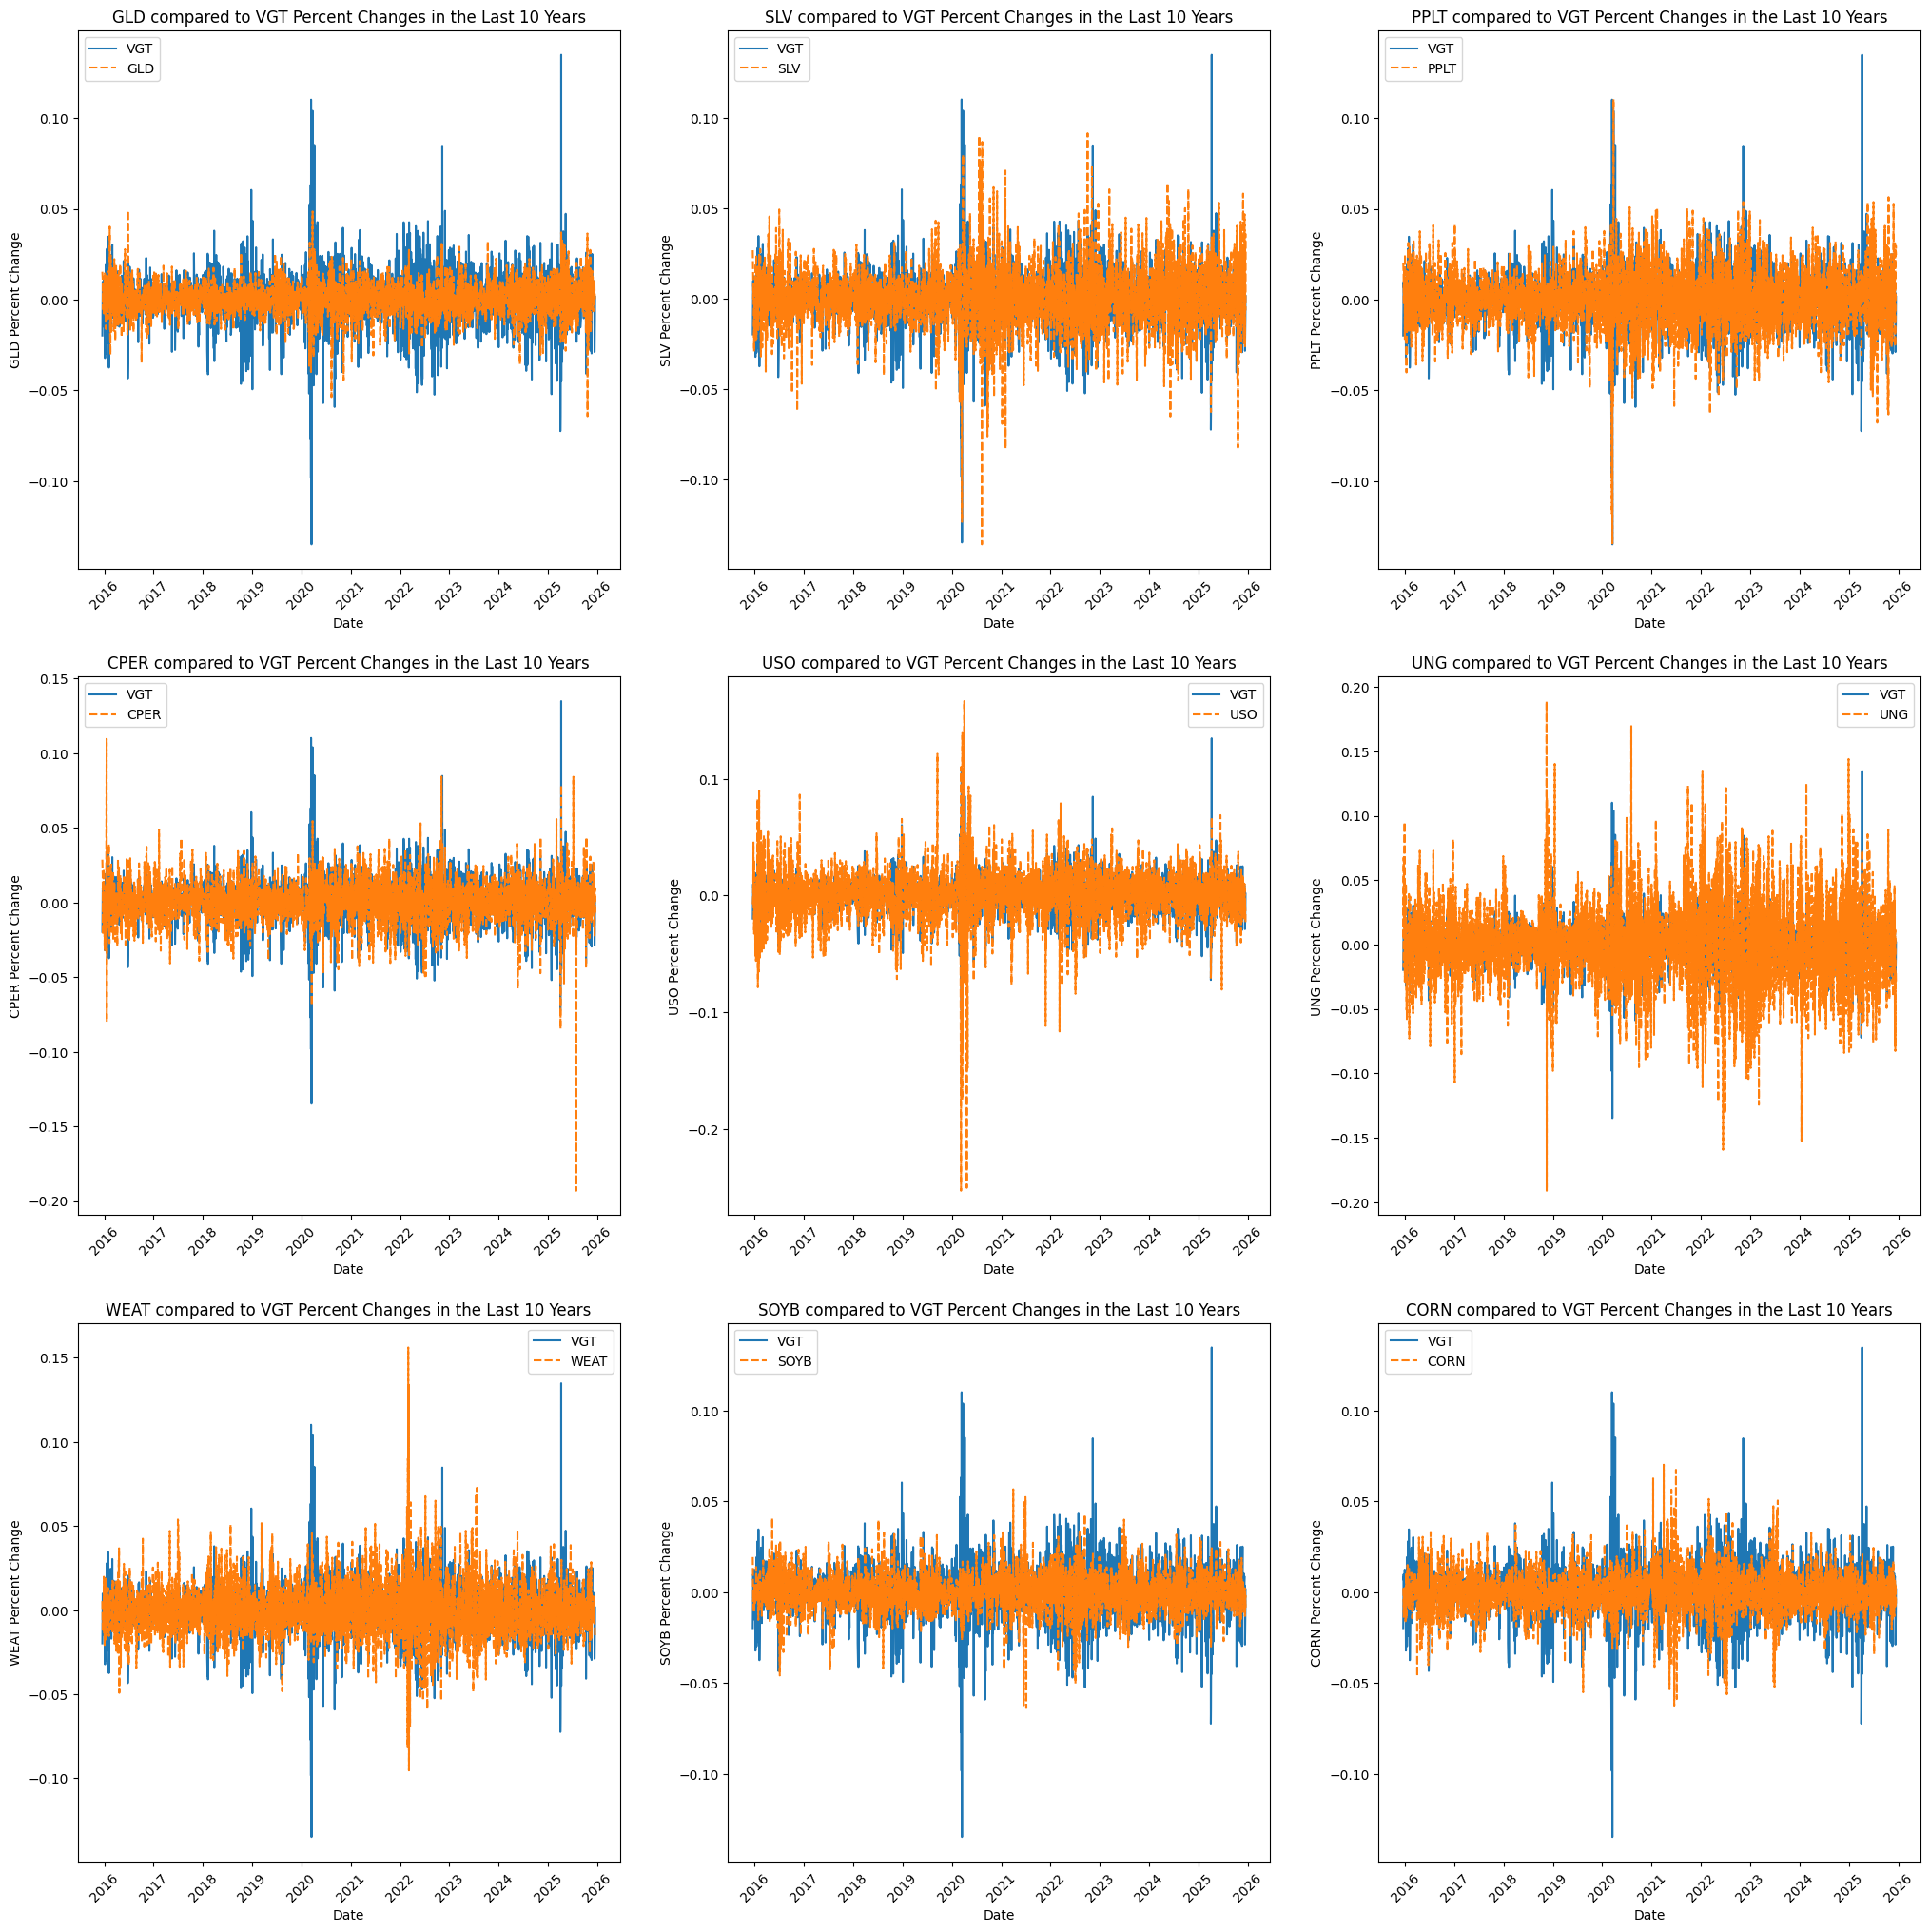

In [67]:
# Plot each commodity compared to VGT
fig, ax = plt.subplots(3, 3, figsize = (25, 25))

# Flatten axes for ease
ax = ax.flatten()

# Iterate over each commodity
for (index, commodity) in enumerate(commodities[:-1]):
  sns.lineplot(data = commodity_pct_change[['VGT', commodity]], ax = ax[index])
  ax[index].set_xlabel('Date')
  ax[index].tick_params(axis = 'x', rotation = 45)
  ax[index].set_ylabel(f'{commodity} Percent Change')
  ax[index].set_title(f'{commodity} compared to VGT Percent Changes in the Last 10 Years');

# Building Classification Models
Now, we define our features as the commodity percent changes. Because the goal is to predict VGT's direction of movement, we represent any positive percent change as a 1 and represent any negative (or zero) percent change as 0. This will be our target column.. This will be our target column.

We will use the following models:

*   Logistic Regression
*   K-Neighbors Classification
*   XGB Classification

To evaluate our models, we can use precision or an F-beta score. Assuming this model only applies to long VGT, it is bad to predict VGT goes up when it actually goes down (incurring losses), but not as bad to predict VGT goes down when it actually goes up (missing gains). If the investor wants to avoid losses, precision is a good evaluator. However, if the investor avoids all losses, they would never make any money. The F-beta score provides a metric that is a mix of both precision and recall, balancing loss aversion and gain aversion. We will use a beta of 0.5 to prioritize precision.

In [68]:
# Define features
X = commodity_pct_change.drop(columns = ['VGT'])

# Define target where positive pct_change is classified as up (1) and negative or 0 pct_change is classified as down (0)
y = np.where((commodity_pct_change['VGT'] > 0), 1, 0)

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12)

In [69]:
# Define data transformer
transformer = StandardScaler()

In [70]:
# @title Baseline
# Determine baseline
days_up = pd.Series(y).value_counts()[1]
days_down = pd.Series(y).value_counts()[0]
print(f'Days up: {days_up}')
print(f'Days down: {days_down}')
print(f'Percent of days up{100 * (days_up / (days_up + days_down)): .2f}%')
print(f'Percent of days down{100 * (days_down / (days_up + days_down)): .2f}%')

Days up: 1435
Days down: 1078
Percent of days up 57.10%
Percent of days down 42.90%


In [71]:
# Scores dataframe to add model scores to

scores_df = scores_df = pd.DataFrame(columns=[
    'Model',
    'Precision Score',
    'F-Beta Score'
])

In [72]:
# @title Logistic Regression Model

# Instantiate
lr = LogisticRegression()

# Create a pipe
lr_pipe = Pipeline([('transformer', transformer), ('model', lr)])

# Fit
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer', StandardScaler()),
                ('model', LogisticRegression())])

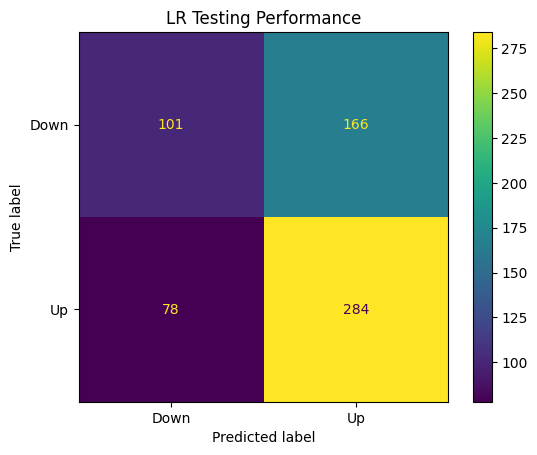

In [73]:
# Evalute model
ConfusionMatrixDisplay.from_estimator(lr_pipe, X_test, y_test, display_labels = ['Down', 'Up'])
plt.title('LR Testing Performance');

In [74]:
# Precision Score
precision_score(y_test, lr_pipe.predict(X_test))

0.6311111111111111

In [75]:
# F-Beta Score
fbeta_score(y_test, lr_pipe.predict(X_test), beta = 0.5)

0.6567992599444958

In [76]:
# Adding scores to dataframe

scores_df.loc[len(scores_df)] = {
    'Model': 'Logistic Regressor',
    'Precision Score': precision_score(y_test, lr_pipe.predict(X_test)),
    'F-Beta Score': fbeta_score(y_test, lr_pipe.predict(X_test), beta = 0.5)
}

In [77]:
# @title K-Nearest Neighbors Classification Model

# Instantiate
knn = KNeighborsClassifier()

# Create a pipe
knn_pipe = Pipeline([('transformer', transformer), ('model', knn)])

# Fit
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer', StandardScaler()),
                ('model', KNeighborsClassifier())])

In [78]:
# Define parameters
knn_params = {'model__n_neighbors': np.arange(1, 30, 2)}

# Initialize a grid search
knn_grid_search = GridSearchCV(estimator = knn_pipe, param_grid = knn_params, scoring = 'precision')

# Fit grid search
knn_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])},
             scoring='precision')

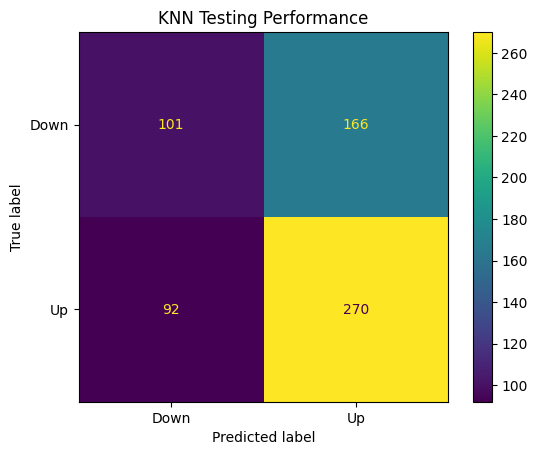

In [79]:
# Visualize performance of the model
ConfusionMatrixDisplay.from_estimator(knn_grid_search, X_test, y_test, display_labels = ['Down', 'Up'])
plt.title('KNN Testing Performance');

In [80]:
# Print best param
print(f'Optimal Number of Neighbors: {knn_grid_search.best_params_}')

# Print best precision score
print(f'Best Precision Score: {precision_score(y_test, knn_grid_search.predict(X_test))}')

# Print best F-beta score
print(f'Best F-beta Score: {fbeta_score(y_test, knn_grid_search.predict(X_test), beta = 0.5)}')

Optimal Number of Neighbors: {'model__n_neighbors': np.int64(15)}
Best Precision Score: 0.6192660550458715
Best F-beta Score: 0.6410256410256411


In [81]:
# Adding scores to dataframe

scores_df.loc[len(scores_df)] = {
    'Model': 'K-Nearest Neighbours',
    'Precision Score': precision_score(y_test, knn_pipe.predict(X_test)),
    'F-Beta Score': fbeta_score(y_test, knn_pipe.predict(X_test), beta = 0.5)
}

In [82]:
# @title XGB Classification Model

# Instantiate
xgbc = XGBClassifier()

# Create a pipe
xgbc_pipe = Pipeline([('transformer', transformer), ('model', xgbc)])

# Fit
xgbc_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [83]:
# Define parameters
xgbc_params = {'model__max_depth': np.arange(1, 30, 2)}

# Initialize a grid search
xgbc_grid_search = GridSearchCV(estimator = xgbc_pipe, param_grid = xgbc_params, scoring = 'precision')

# Fit grid search
xgbc_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'model__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])},
             scoring='precision')

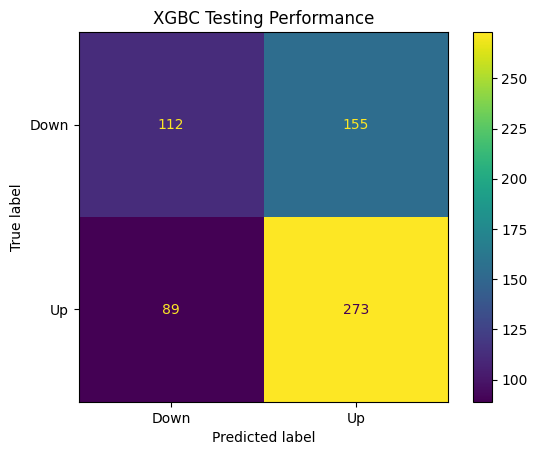

In [84]:
# Evalute model
ConfusionMatrixDisplay.from_estimator(xgbc_grid_search, X_test, y_test, display_labels = ['Down', 'Up'])
plt.title('XGBC Testing Performance');

In [85]:
# Print best param
print(f'Optimal Max Depth: {xgbc_grid_search.best_params_}')

# Print best precision score
print(f'Best Precision Score: {precision_score(y_test, xgbc_grid_search.predict(X_test))}')

# Print best F-beta score
print(f'Best F-beta Score: {fbeta_score(y_test, xgbc_grid_search.predict(X_test), beta = 0.5)}')

Optimal Max Depth: {'model__max_depth': np.int64(1)}
Best Precision Score: 0.6378504672897196
Best F-beta Score: 0.6581485053037609


In [86]:
# Adding scores to dataframe

scores_df.loc[len(scores_df)] = {
    'Model': 'XGB Classifier',
    'Precision Score': precision_score(y_test, xgbc_pipe.predict(X_test)),
    'F-Beta Score': fbeta_score(y_test, xgbc_pipe.predict(X_test), beta = 0.5)
}

# Neural Net Model

In [87]:
# Convert training and test features to PyTorch tensors
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test.values,  dtype=torch.float32)

# Convert labels to tensors and reshape to (N, 1)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_torch  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

In [88]:
# Neural Network Model
model = nn.Sequential(nn.Linear(9,128), # Input/first hidden layer, 9 inputs, 128 neurons
                       nn.ReLU(), # Activation layer
                       nn.Linear(128,64), # Second hidden layer, 128 inputs, 64 neurons
                       nn.ReLU(),
                       nn.Linear(64,32), # Third hidden layer, 64 inputs, 32 neurons
                       nn.ReLU(),
                       nn.Linear(32,1)) # Output layer, 32 inputs, 1 output


In [89]:
# Empty list to append losses to
losses = []

# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer to update weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop for 50 epochs
for i in range(50):
    yhat = model(X_train_torch) # Model outputs
    loss = loss_fn(yhat, y_train_torch) # Compute loss
    optimizer.zero_grad() # Clear old gradient
    loss.backward() # Compute gradient
    optimizer.step() # Update weights
    losses.append(loss.item()) # Store loss

Text(0, 0.5, 'Loss')

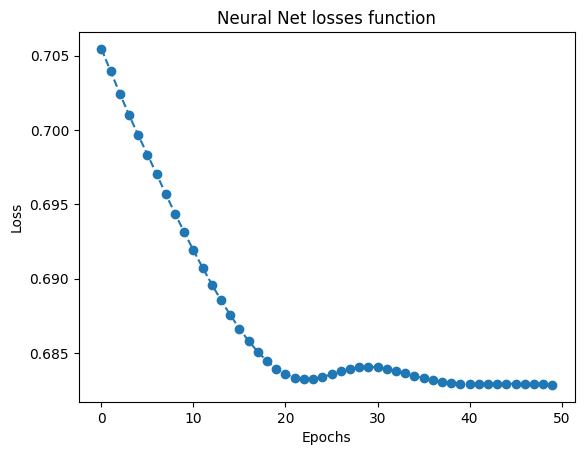

In [90]:
# @title Neural Net Loss Graph

plt.plot(losses, '--o')
plt.title("Neural Net losses function")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [91]:
# Switching model to evaluation mode
model.eval()
with torch.no_grad():
    logits = model(X_test_torch) # Model outputs
    probs = torch.sigmoid(logits) # Converting logits to probabilites
    y_pred = (probs > 0.5).int() # Outputs with probability > 0.5 assigned 1, else 0

# True values for evaluation
y_true = y_test_torch.int()

In [92]:
print(f'Precision score:{precision_score(y_true.numpy(), y_pred.numpy())}')

Precision score:0.575516693163752


In [93]:
print(f'F-Beta score:{fbeta_score(y_true.numpy(), y_pred.numpy(), beta=0.5)}')

F-Beta score:0.6289089645587214


In [94]:
scores_df.loc[len(scores_df)] = {
    'Model': 'Neural Net',
    'Precision Score': precision_score(y_true.numpy(), y_pred.numpy()),
    'F-Beta Score': fbeta_score(y_true.numpy(), y_pred.numpy(), beta=0.5)
}

# Determining Feature Importances
At this point, we compare the important features linked to changes in VGT price across the 3 models.

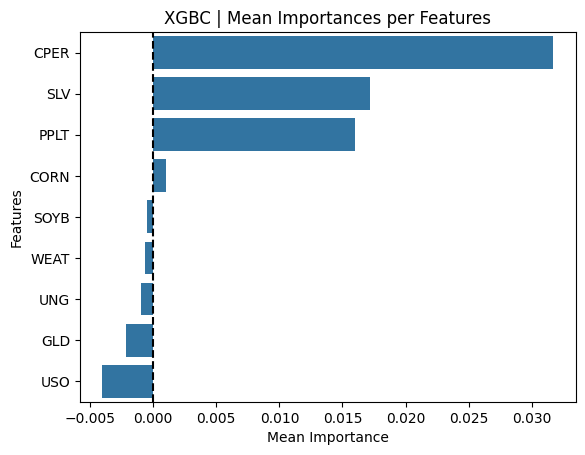

In [95]:
# @title 1. Best Performing - XGB Classification Feature Importances

# Show feature importance
xgbc_importances = permutation_importance(xgbc_grid_search, X_test, y_test, random_state=12)

# Create a data frame to neatly organize
xgbc_importances_df = pd.DataFrame()
xgbc_importances_df['Features'] = X.columns
xgbc_importances_df['Mean Importance'] = xgbc_importances['importances_mean']
xgbc_importances_df['STD Importance'] = xgbc_importances['importances_std']

# Reorder based on the mean importance
xgbc_importances_df.sort_values(by='Mean Importance', inplace=True, ascending=False)

# Plot importances
sns.barplot(data = xgbc_importances_df, x = 'Mean Importance', y = 'Features')
plt.axvline(0, color = 'black', linestyle = '--')
plt.title('XGBC | Mean Importances per Features');

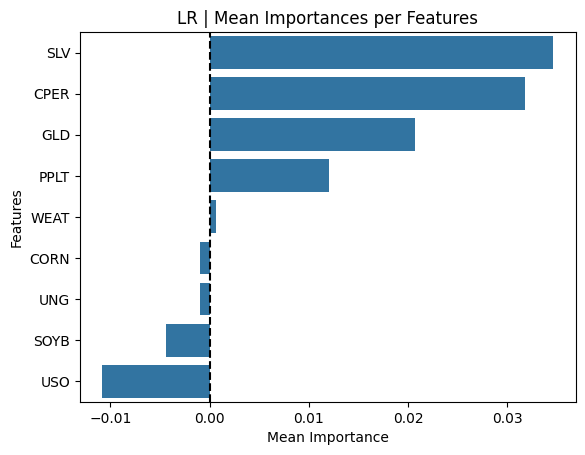

In [96]:
# @title 2. Moderate Performing - Logistic Regression Feature Importances

# Show feature importance
lr_importances = permutation_importance(lr_pipe, X_test, y_test, random_state=12)

# Create a data frame to neatly organize
lr_importances_df = pd.DataFrame()
lr_importances_df['Features'] = X.columns
lr_importances_df['Mean Importance'] = lr_importances['importances_mean']
lr_importances_df['STD Importance'] = lr_importances['importances_std']

# Reorder based on the mean importance
lr_importances_df.sort_values(by='Mean Importance', inplace=True, ascending=False)

# Plot importances
sns.barplot(data = lr_importances_df, x = 'Mean Importance', y = 'Features')
plt.axvline(0, color = 'black', linestyle = '--')
plt.title('LR | Mean Importances per Features');

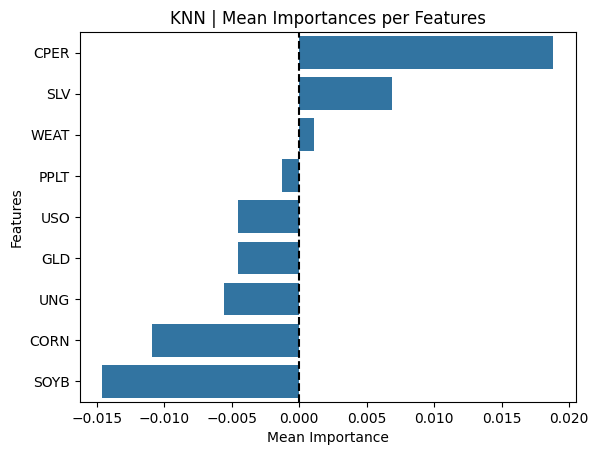

In [97]:
# @title 3. Worst Performing - K-Nearest Neighbors Classification Feature Importances

# Show feature importance
knn_importances = permutation_importance(knn_grid_search, X_test, y_test, random_state=12)

# Create a data frame to neatly organize
knn_importances_df = pd.DataFrame()
knn_importances_df['Features'] = X.columns
knn_importances_df['Mean Importance'] = knn_importances['importances_mean']
knn_importances_df['STD Importance'] = knn_importances['importances_std']

# Reorder based on the mean importance
knn_importances_df.sort_values(by='Mean Importance', inplace=True, ascending=False)

# Plot importances
sns.barplot(data = knn_importances_df, x = 'Mean Importance', y = 'Features')
plt.axvline(0, color = 'black', linestyle = '--')
plt.title('KNN | Mean Importances per Features');

# Comparing Importances
We put all the feature importance information into one dataframe and normalize it, putting it all on the same scale so it can be compared

In [98]:
# @title Combined Dataframe

# Combine feature importances from all three models into one dataframe
imp_compare = (
    xgbc_importances_df[['Features', 'Mean Importance']].rename(columns={'Mean Importance': 'XGBC'})
    .merge(lr_importances_df[['Features', 'Mean Importance']].rename(columns={'Mean Importance': 'LR'}),
           on='Features', how='outer')
    .merge(knn_importances_df[['Features', 'Mean Importance']].rename(columns={'Mean Importance': 'KNN'}),
           on='Features', how='outer')
    .fillna(0) # Replace missing values with 0
    .set_index('Features') # Feature names as index
)

imp_compare

,XGBC,LR,KNN
Features,,,
CORN,0.001022,-0.000954,-0.010900
CPER,0.031718,0.031797,0.018839
GLD,-0.002173,0.020668,-0.004533
PPLT,0.016002,0.012083,-0.001278
SLV,0.017169,0.034658,0.006883
SOYB,-0.000493,-0.004452,-0.014577
UNG,-0.000953,-0.000954,-0.005575
USO,-0.004026,-0.010811,-0.004508
WEAT,-0.000620,0.000636,0.001090


In [99]:
# @title Normalizing Values

# Normalize feature importances so each model’s importances sum to 1
# Making all importances positive, summing them per model, then dividing each importance by total to find proportion
imp_norm = imp_compare.abs().div(imp_compare.abs().sum(axis=0), axis=1)

# Sort features by their average importance across all models (largest first)
imp_norm = imp_norm.loc[imp_norm.mean(axis=1).sort_values(ascending=False).index]
imp_norm

,XGBC,LR,KNN
Features,,,
CPER,0.427614,0.271739,0.276294
SLV,0.231464,0.296196,0.100945
PPLT,0.215736,0.103261,0.018739
GLD,0.029294,0.176630,0.066488
SOYB,0.006648,0.038043,0.213798
USO,0.054274,0.092391,0.066118
CORN,0.013774,0.008152,0.159868
UNG,0.012842,0.008152,0.081768
WEAT,0.008354,0.005435,0.015981


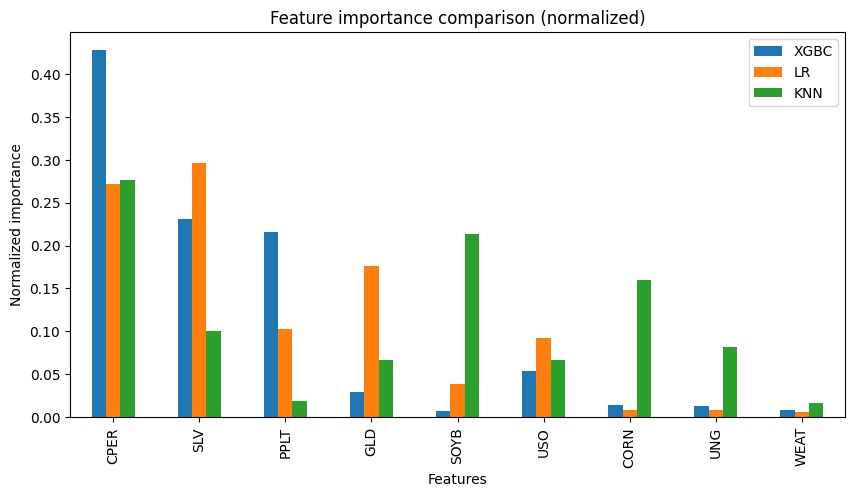

In [100]:
# @title Comparison Plot

ax = imp_norm.plot(kind='bar', figsize=(10, 5))
ax.set_ylabel('Normalized importance')
ax.set_title('Feature importance comparison (normalized)')
plt.show()

# Comparing Scores
Now, we compare the precision and f-beta of each model, determining which is best


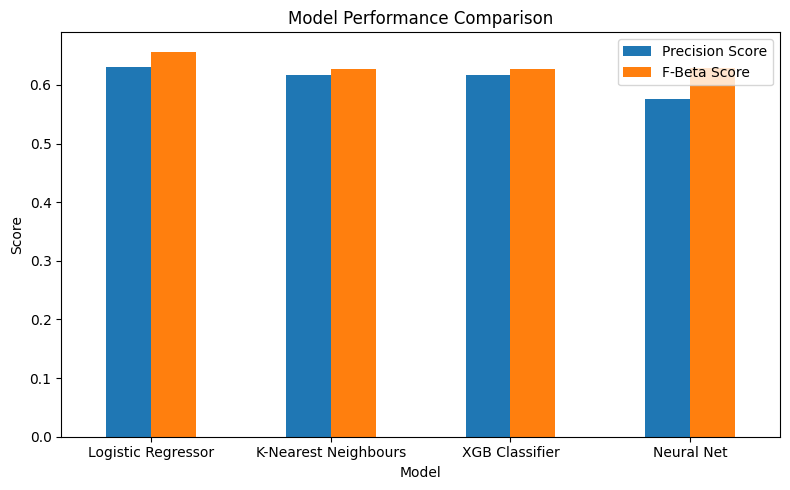

In [101]:
scores_df.set_index('Model')[['Precision Score', 'F-Beta Score']].plot(
    kind='bar',
    figsize=(8, 5)
)

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# Sentiment Analysis
We decided to also employ the use of the tabularisai/multilingual-sentiment-analysis library on HuggingFace to get an idea of what people think about stocks. We scraped many subreddits, looking for mentions of the commodities

In [102]:
# @title Sentiment Analyzer Initialization

# Initialize model
model_name = 'tabularisai/multilingual-sentiment-analysis'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function from "how to" section on huggingface page

# Predict sentiment labels for a list of texts
def predict_sentiment(texts):
    # Convert text into tensors
    inputs = tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )

    # Run model without tracking gradients
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert model outputs to probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Map numeric labels to sentiment names
    sentiment_map = {
        0: 'Very Negative',
        1: 'Negative',
        2: 'Neutral',
        3: 'Positive',
        4: 'Very Positive'
    }

    # Return the sentiment with the highest probability
    return [
        sentiment_map[p]
        for p in torch.argmax(probabilities, dim=-1).tolist()
    ]

In [103]:
# List of subreddits to scrape
subredditlist = [
    'news', 'worldnews', 'breakingnews', 'globalnews',
    'wallstreetbets', 'stockmarket', 'stocks',
    'trading', 'daytrading', 'economics', 'economy',
]

In [104]:
# List of commodities to look for in posts
commodity_names = ['gold', 'silver', 'platinum', 'copper', 'oil', 'gas', 'wheat', 'soybean', 'corn']

In [105]:
# Get sentiment for a single piece of text
def predict_sentiment_one(text):
    if not isinstance(text, str) or text.strip() == '':
        return None
    return predict_sentiment([text])[0]

# Find which commodities appear in a text
def find_commodities(text):
    if not isinstance(text, str):
        return []
    words = text.lower().split()
    found = []
    for c in commodity_names:
        if c in words:
            found.append(c)
    return found

In [106]:
# Empty list to append to
all_rows = []

# Loop through each subreddit
for item in subredditlist:
    # Connect to Reddit
    subscraper = praw.Reddit(
        client_id='xdpuZuV2hoBM9kQDBhNKNQ',
        client_secret='sSoQR5rsBFHvH6XtMwN7Oy0xSJiZRw',
        user_agent='sub-activity-check by u/Flaky-Pattern4439',
        check_for_async=False
    )
    sub = subscraper.subreddit(item)

    # Get top posts from the past month
    posts = list(sub.top(time_filter='month', limit=500))

    # Loop through posts
    for post in posts:
        title = post.title
        body = post.selftext

        # Combine title and body for commodity detection
        text = f'{title} {body}'
        mentioned = find_commodities(text)

        # Skip posts with no commodities
        if not mentioned:
            continue

        # Get sentiment of title and body
        title_sent = predict_sentiment_one(title)
        body_sent = predict_sentiment_one(body)

        # Save post information
        all_rows.append({
            'Subreddit': item,
            'Commodities mentioned': mentioned,
            'Title': title,
            'Body': body,
            'Title Sentiment': title_sent,
            'Body Sentiment': body_sent
        })

# Create dataframe of all collected posts
posts_df = pd.DataFrame(
    all_rows,
    columns=[
        'Subreddit',
        'Commodities mentioned',
        'Title',
        'Body',
        'Title Sentiment',
        'Body Sentiment'
    ]
)

# Count how many times each commodity is mentioned
commodity_counts_df = (
    posts_df
    .explode('Commodities mentioned')           # one row per commodity mention
    .groupby('Commodities mentioned', as_index=False)
    .size()                                     # count mentions
    .rename(columns={
        'Commodities mentioned': 'Commodity',
        'size': 'Number of mentions'
    })
    .sort_values('Number of mentions', ascending=False)
    .reset_index(drop=True)
)


In [107]:
# @title Commodity Mentions

commodity_counts_df

,Commodity,Number of mentions
0,gold,27
1,oil,19
2,silver,9
3,gas,5


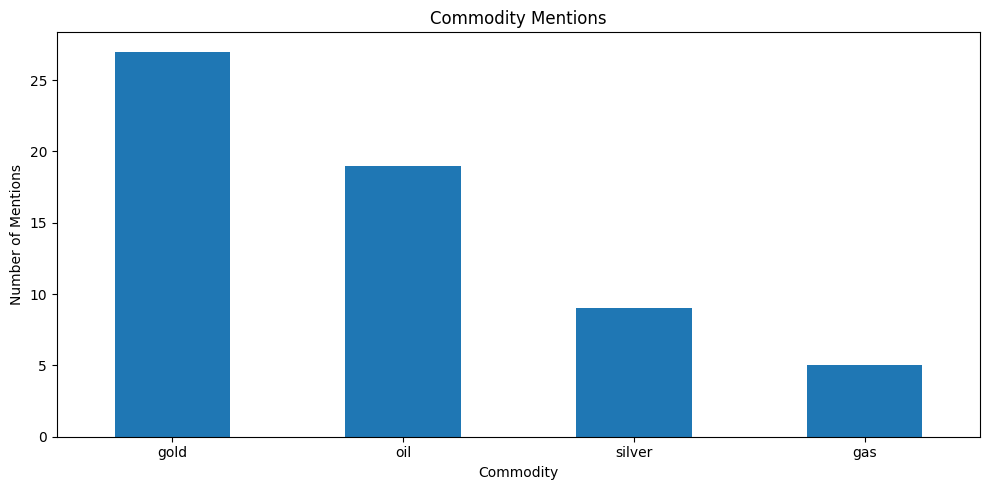

In [108]:
commodity_counts_df.set_index('Commodity')['Number of mentions'].plot(
    kind='bar',
    figsize=(10, 5)
)
plt.title('Commodity Mentions')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [109]:
# @title Post Sentiment Information

posts_df

,Subreddit,Commodities mentioned,Title,Body,Title Sentiment,Body Sentiment
0,news,[oil],U.S. seizes oil tanker off the coast of Venezu...,,Neutral,None
1,news,[oil],US sanctions six more ships after seizing oil ...,,Neutral,None
2,worldnews,[oil],Ukraine Hits Two Oil Facilities in Russia in O...,,Neutral,None
3,worldnews,[gold],Russia Starts Selling Off Its Gold Reserves to...,,Very Positive,None
4,worldnews,[oil],Colombia bans all new oil and mining projects ...,,Neutral,None
5,worldnews,[oil],Russia demands Trump administration provide re...,,Neutral,None
6,worldnews,[oil],Trump plans envision major U.S. investment in ...,,Neutral,None
7,worldnews,[oil],Colombian president says oil is ‘at the heart ...,,Neutral,None
8,worldnews,[oil],Ukraine Hits Russian Oil Platform in the Caspi...,,Neutral,None
9,worldnews,[oil],Russia's flagship oil price drops as buyers re...,,Neutral,None


In [110]:
# @title Counting Unique Sentiments for Each Commodity in Titles and Bodies

title_counts = (
    posts_df
    .explode('Commodities mentioned')
    .groupby(['Commodities mentioned', 'Title Sentiment'])
    .size()
    .unstack(fill_value=0) # Missing values assigned 0
)

body_counts = (
    posts_df
    .explode('Commodities mentioned')
    .groupby(['Commodities mentioned', 'Body Sentiment'])
    .size()
    .unstack(fill_value=0) # Missing values assigned 0
)


In [111]:
# @title Commodity Sentiments in Titles

title_counts

Title Sentiment,Negative,Neutral,Positive,Very Negative,Very Positive
Commodities mentioned,,,,,
gas,2,3,0,0,0
gold,0,21,1,1,4
oil,1,18,0,0,0
silver,1,7,0,0,1


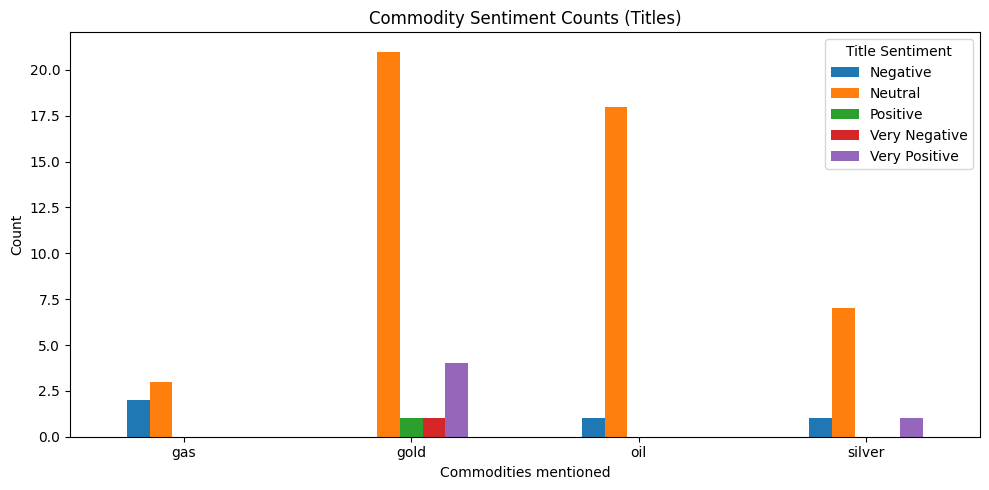

In [112]:
title_counts.plot(
    kind='bar',
    figsize=(10, 5)
)
plt.title('Commodity Sentiment Counts (Titles)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [113]:
# @title Commodity Sentiments in Bodies

body_counts

Body Sentiment,Negative,Neutral,Positive,Very Negative,Very Positive
Commodities mentioned,,,,,
gas,1,0,0,0,1
gold,3,18,0,3,1
oil,1,1,1,1,0
silver,2,6,0,1,0


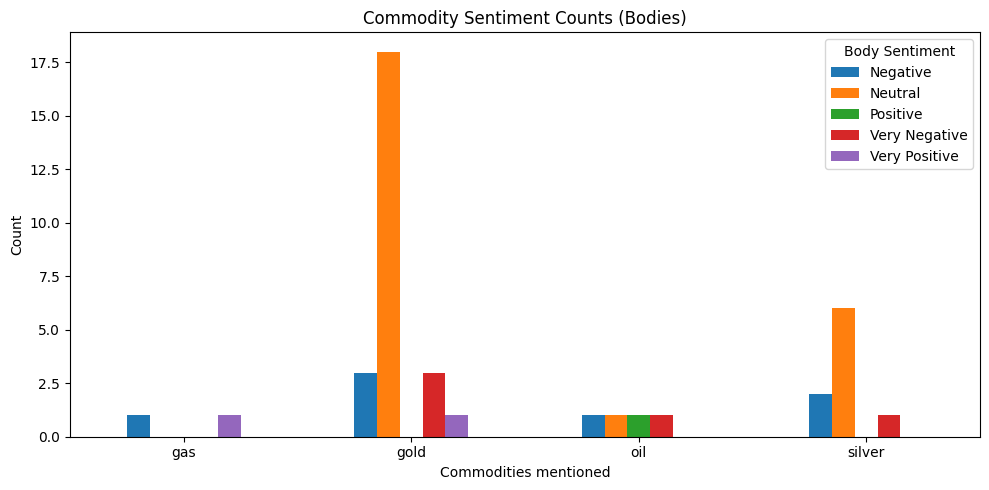

In [114]:
body_counts.plot(
    kind='bar',
    figsize=(10, 5)
)
plt.title('Commodity Sentiment Counts (Bodies)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [115]:
total_counts = title_counts.add(body_counts, fill_value=0).astype(int)

In [116]:
# @title Commodity Sentiments in Titles and Bodies Combined

total_counts

Title Sentiment,Negative,Neutral,Positive,Very Negative,Very Positive
Commodities mentioned,,,,,
gas,3,3,0,0,1
gold,3,39,1,4,5
oil,2,19,1,1,0
silver,3,13,0,1,1


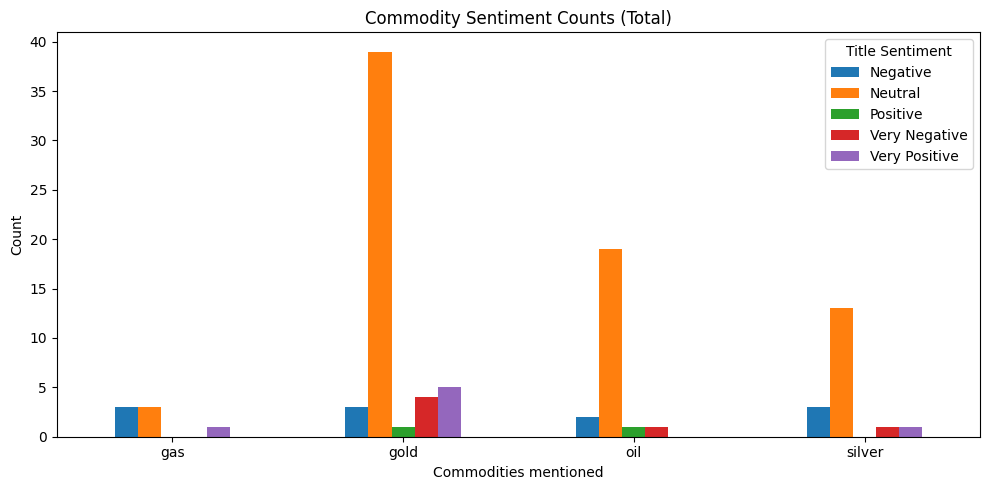

In [117]:
total_counts.plot(
    kind='bar',
    figsize=(10, 5)
)
plt.title('Commodity Sentiment Counts (Total)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
